In [ ]:
!pip install praw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import praw
import pandas as pd
from datetime import date
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [11]:
reddit = praw.Reddit(check_for_async=False)

# Create name string using download date
search_tuple = [
    ('LosAngeles', 'parking'), 
    ('all', 'Los Angeles parking'),
    ('LosAngeles', 'parking regulation'),
    ('all', 'Los Angeles parking regulation')]

df = pd.DataFrame({'title':[]})
for tup1, tup2 in search_tuple:

    la_subreddit = reddit.subreddit(tup1)
    la_subreddit_new =  la_subreddit.search(tup2, limit=5000)
    for submission in la_subreddit_new:
        df = df.append({'title': submission.title, 
                        'selftext' : submission.selftext,
                        'votes': submission.score,
                        'upvote_ratio' : submission.upvote_ratio,
                        'url': submission.url,
                        'permalink': submission.permalink
                        }, ignore_index=True)
 

In [12]:
# Examine raw data structure
df.head()

,title,permalink,selftext,upvote_ratio,url,votes
0,What beach has the shortest distance from park...,/r/LosAngeles/comments/vv0gu3/what_beach_has_t...,My disabled cousin can not walk across the san...,0.95,https://www.reddit.com/r/LosAngeles/comments/v...,225.0
1,A beautiful sunset and parking lot tacos,/r/LosAngeles/comments/w71c9j/a_beautiful_suns...,,0.96,https://i.imgur.com/Ri5kWY2.jpg,262.0
2,"Man, does Echo Park Lake clean up nice",/r/LosAngeles/comments/wb7y8d/man_does_echo_pa...,,0.94,https://imgur.com/Dxtjcim.jpg,1223.0
3,Found this little guy in a parking lot ! Don’t...,/r/LosAngeles/comments/vh0g5j/found_this_littl...,,0.97,https://i.redd.it/xzbkrlh3fv691.jpg,488.0
4,Came back to a nice surprise after parking at ...,/r/LosAngeles/comments/vg8syq/came_back_to_a_n...,,0.97,https://i.redd.it/ipu0xur59o691.jpg,299.0


In [13]:
# Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         766 non-null    object 
 1   permalink     766 non-null    object 
 2   selftext      766 non-null    object 
 3   upvote_ratio  766 non-null    float64
 4   url           766 non-null    object 
 5   votes         766 non-null    float64
dtypes: float64(2), object(4)
memory usage: 36.0+ KB


In [14]:
df.title[0]

'What beach has the shortest distance from parking to ocean.'

In [17]:
# Download NLTK libaries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /Users/gregpawin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregpawin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gregpawin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gregpawin/nltk_data...


In [15]:
# Function that creates list of bi- or tri-grams, 
def create_grams(input_df: pd.DataFrame, gram: str='bi') -> list: 
    ''' Takes input file path and combines title and self_text columns,
    tokenizes, removes stopwords, lemmatizes, and looks for either bi- or
    tri-grams and puts it all in one list.
    '''

    # Combine title and self_text
    df['title_selftext'] = df['title'] + df['selftext']

    # Change all words into lowercase
    df['title_selftext'] = df['title_selftext'].apply(lambda x: x.lower())

    # Tokenize
    df['tokens'] = df.title_selftext.apply(lambda x: 
            nltk.RegexpTokenizer(r'\w+').tokenize(x))

    # Remove stop words and lemmatize using WordNetLemmatizer
    wnl = WordNetLemmatizer()
    df['tokens'] = df['tokens'].apply(lambda x: [wnl.lemmatize(w) 
            for w in x if not w in stop_words])

    # Apply bigram, trigram, or error
    if gram=='bi':
        df['grams'] = df['tokens'].apply(nltk.bigrams)
    elif gram=='tri':
        df['grams'] = df['tokens'].apply(nltk.trigrams)
    else:
        raise NameError('Only bi or tri allowed')

    # Return combined list of bi-grams
    return [' '.join(item) for sublist in df.grams for item in sublist]


In [18]:
# # Apply create_grams to all raw data and count bi-grams
# bigram_list = []
# for path in (PROJECT_DIR / 'data' / 'raw').glob("*.json"):
#     bigram_list = bigram_list + create_grams(path)
combined_bigrams = pd.Series(create_grams(df))
biggram_counts = combined_bigrams[combined_bigrams.str.contains('parking')].value_counts()
biggram_counts[:10]



parking lot            104
angeles parking         95
parking enforcement     57
parking ticket          23
parking regulation      21
parking fine            19
parking violation       17
overnight parking       14
parking sign            14
parking meter           14
dtype: int64

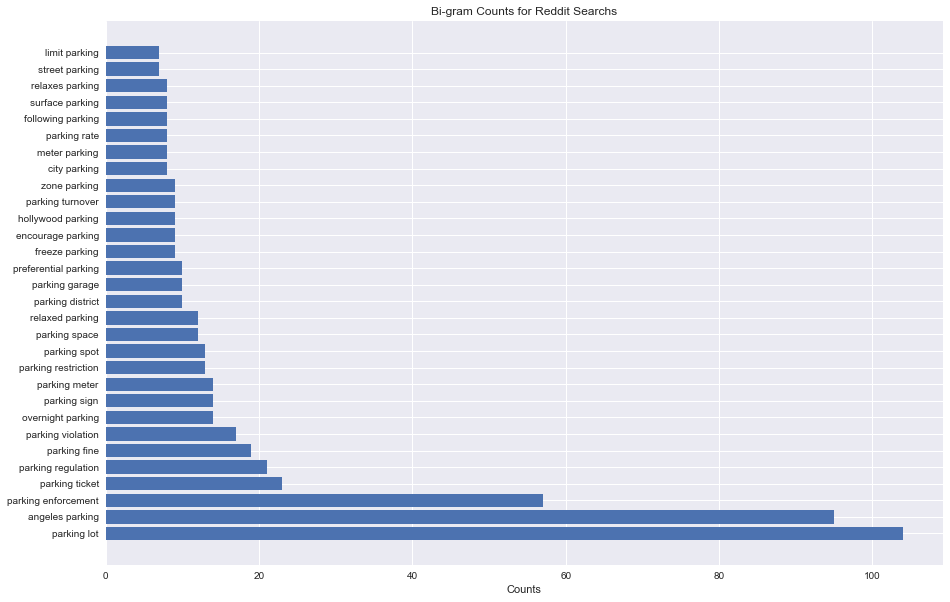

In [19]:
# Plot top 30 bi-grams
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
plt.barh(biggram_counts[:30].index, biggram_counts[:30].values)
plt.title('Bi-gram Counts for Reddit Searchs')
plt.xlabel('Counts')
plt.show()



In [20]:
combined_trigram = pd.Series(create_grams(df, 'tri'))
trigram_counts = combined_trigram[combined_trigram.str.contains('parking')].value_counts()
trigram_counts[:10]

los angeles parking              95
angeles parking lot              23
parking enforcement http         15
angeles parking enforcement      15
parking violation bureau         11
vehicle overnight parking        10
parking lot tailgating           10
parking fine increase            10
relaxed parking enforcement      10
preferential parking district    10
dtype: int64

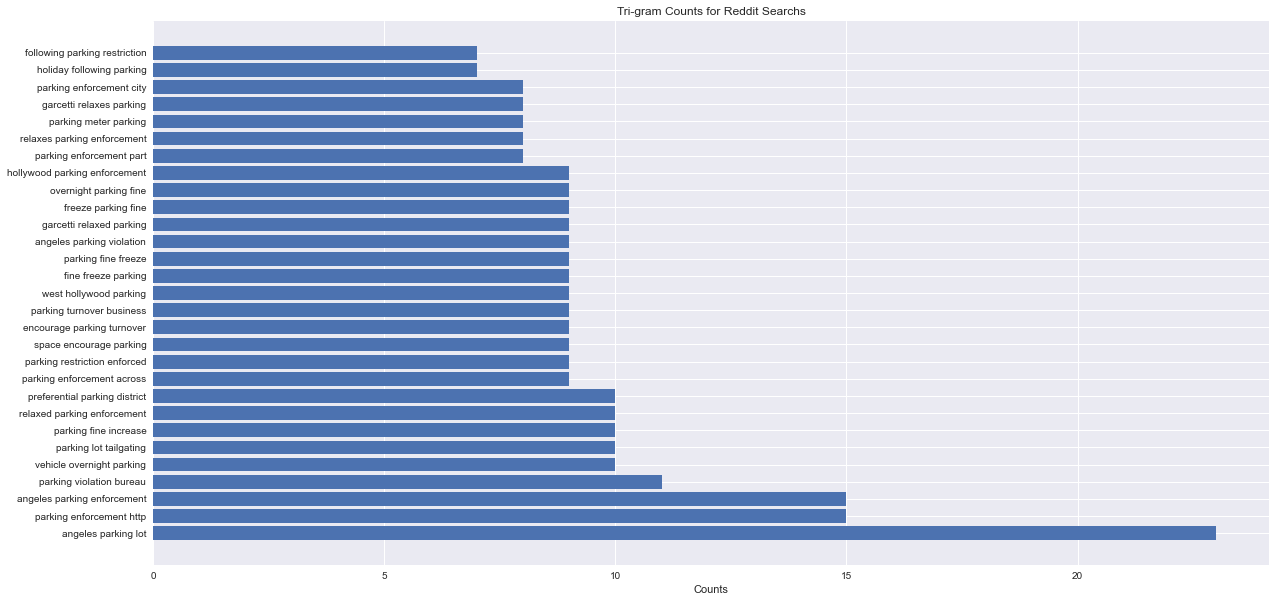

In [21]:
# Plot top 30 tri-grams
# Removed first result "los angeles parking"
plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.barh(trigram_counts[1:30].index, trigram_counts[1:30].values)
plt.title('Tri-gram Counts for Reddit Searchs')
plt.xlabel('Counts')
plt.show()

